# Importing Libraries

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from quantile_forest import RandomForestQuantileRegressor
from keras.models import Sequential
from sklearn.metrics import mean_absolute_error
from numpy.lib.stride_tricks import sliding_window_view
import seaborn as sns
import tensorflow as tf

# Loading Dataset

In [36]:
df = pd.read_csv('DE_utc.csv')
df.head()

,DateTime,Price[EUR/MWh],Load_DA[GW],Load_Actual[GW],Solar_DA[GW],Solar_Actual[GW],WindOnshore_DA[GW],WindOnshore_Actual[GW],WindOffshore_DA[GW],WindOffshore_Actual[GW],Temperature_DA[C],Temperature_Actual[C],Coal_fM,Gas_fD,Gas_fM,Gas_fQ,Gas_fY,Oil_fM,EUA_fM,EUR_USD
0,2015-01-04T23:00:00Z,22.34,43.17617,46.66787,0.0,0.0,0.19212,0.47802,10.00974,12.71664,NaN,2.05,53.42,19.8,20.145,19.681,20.4,44.51,6.9,1.193317
1,2015-01-05T00:00:00Z,17.93,41.59758,44.62704,0.0,0.0,0.19238,0.46855,10.28754,12.59640,NaN,2.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-05T01:00:00Z,15.17,40.42159,43.63534,0.0,0.0,0.19500,0.46556,10.41837,12.81819,NaN,2.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-05T02:00:00Z,16.38,40.40436,43.68339,0.0,0.0,0.19362,0.45402,10.60180,13.01156,NaN,1.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-05T03:00:00Z,17.38,41.34813,44.96917,0.0,0.0,0.18762,0.45748,10.80991,13.54185,NaN,1.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Exploratory Data Analysis (EDA)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81695 entries, 0 to 81694
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   DateTime                 81695 non-null  object 
 1   Price[EUR/MWh]           81622 non-null  float64
 2   Load_DA[GW]              81693 non-null  float64
 3   Load_Actual[GW]          81675 non-null  float64
 4   Solar_DA[GW]             81695 non-null  float64
 5   Solar_Actual[GW]         81675 non-null  float64
 6   WindOnshore_DA[GW]       81695 non-null  float64
 7   WindOnshore_Actual[GW]   81675 non-null  float64
 8   WindOffshore_DA[GW]      81695 non-null  float64
 9   WindOffshore_Actual[GW]  81675 non-null  float64
 10  Temperature_DA[C]        27144 non-null  float64
 11  Temperature_Actual[C]    81695 non-null  float64
 12  Coal_fM                  2431 non-null   float64
 13  Gas_fD                   2432 non-null   float64
 14  Gas_fM                

## Converting **Datetime** from string to time format:

In [38]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)

## Handeling Missing target values and Features ##
- Since the missing values for the price, which is our target variable, are concentrated at the end of the dataset, the last 72 rows, removing these rows will have minimal impact on our analysis.
- Since we had limited data for 'Temperature_DA[C]', we decided to drop this feature and instead use 'Temperature_Actual[C]'.
- For the remaining features with missing values, since we have only one value for each day and it is the same for the whole day, we use forward filling strategy to handel the missing values.

In [39]:
df.isnull().sum()

Price[EUR/MWh]                73
Load_DA[GW]                    2
Load_Actual[GW]               20
Solar_DA[GW]                   0
Solar_Actual[GW]              20
WindOnshore_DA[GW]             0
WindOnshore_Actual[GW]        20
WindOffshore_DA[GW]            0
WindOffshore_Actual[GW]       20
Temperature_DA[C]          54551
Temperature_Actual[C]          0
Coal_fM                    79264
Gas_fD                     79263
Gas_fM                     79263
Gas_fQ                     79263
Gas_fY                     79263
Oil_fM                     79264
EUA_fM                     79264
EUR_USD                    79263
dtype: int64

In [40]:
df = df[:-73]
df.drop('Temperature_DA[C]', axis=1, inplace=True)
df.isnull().sum()

Price[EUR/MWh]                 1
Load_DA[GW]                    2
Load_Actual[GW]                0
Solar_DA[GW]                   0
Solar_Actual[GW]               0
WindOnshore_DA[GW]             0
WindOnshore_Actual[GW]         0
WindOffshore_DA[GW]            0
WindOffshore_Actual[GW]        0
Temperature_Actual[C]          0
Coal_fM                    79192
Gas_fD                     79192
Gas_fM                     79192
Gas_fQ                     79192
Gas_fY                     79192
Oil_fM                     79192
EUA_fM                     79192
EUR_USD                    79192
dtype: int64

In [41]:
df.fillna(method='ffill', inplace=True)
df.isnull().sum().sum()

0

## Visualization ##

This time series dataset contains 81695 hourly observations of day-ahead electricity prices(EUR/MWh) of Germany-Luxembourg(+Austria until Oct.2018) from January 2015 to April 2024. The figure below shows the electricity prices over the course of the study. 

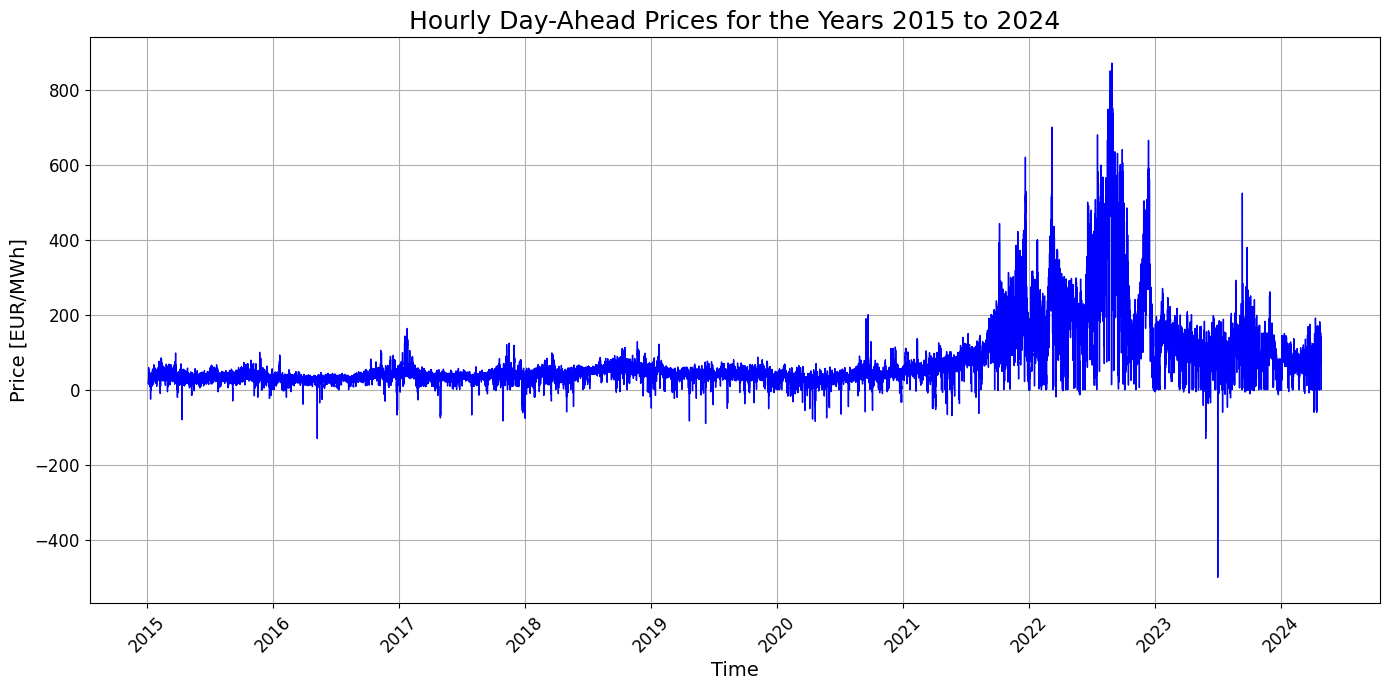

In [42]:
plt.figure(figsize=(14, 7))
plt.plot(df['Price[EUR/MWh]'], label='Price[EUR/MWh]', color='blue', linewidth=1)

plt.title('Hourly Day-Ahead Prices for the Years 2015 to 2024', fontsize=18)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Price [EUR/MWh]', fontsize=14)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.savefig('price_plot.png', dpi=300)
plt.show()

In [43]:
top_5_max_values = df['Price[EUR/MWh]'].nlargest(5)
top_5_min_values = df['Price[EUR/MWh]'].nsmallest(5)

print("Top 5 Maximum Values:")
print(top_5_max_values)

print("\nTop 5 Minimum Values:")
print(top_5_min_values)

Top 5 Maximum Values:
DateTime
2022-08-29 17:00:00+00:00    871.00
2022-08-29 18:00:00+00:00    860.89
2022-08-30 17:00:00+00:00    855.46
2022-08-24 17:00:00+00:00    850.00
2022-08-29 16:00:00+00:00    837.66
Name: Price[EUR/MWh], dtype: float64

Top 5 Minimum Values:
DateTime
2023-07-02 12:00:00+00:00   -500.00
2023-07-02 13:00:00+00:00   -399.00
2023-07-02 11:00:00+00:00   -266.92
2023-07-02 10:00:00+00:00   -167.96
2016-05-08 12:00:00+00:00   -130.09
Name: Price[EUR/MWh], dtype: float64


"Following Russia's invasion of Ukraine, there was a huge increase in prices on the wholesale markets for electricity, gas and coal. Electricity prices were extremely volatile and closely connected to gas price trends.

The main reason for the higher prices for electricity over the year was the increase in natural gas prices that occurred in the second half of 2021. Natural gas power plants set the price for many hours in European wholesale electricity trading. The last quarter of 2022 saw a decrease in electricity prices, which then continued in 2023".

- On July 2, 2023, the electricity price experienced a dramatic decline, plummeting from -266.92 euros at 11:00 to -500 euros at 12:00, and remaining extremely low at -399 euros at 13:00. Such extreme price fluctuations can impact data scaling and analysis. To mitigate the influence of these anomalies, we replaced the extreme values with the price recorded at 10:00, which was -167.96 EUR/MWh. This adjustment helps to smooth out the data and improve its stability for subsequent analysis.

- In August 2022, the electricity price reached a peak of 871 EUR/MWh. Despite this significant spike, the high prices were consistent throughout the month. We will retain these values in the dataset, as they represent real market conditions and altering them could impact the accuracy of our analysis.


In [44]:
# Replace values less than -200 with the price recorded at 10:00, which was -167.96 EUR/MWh.
df.loc[(df.index.date == pd.Timestamp('2023-07-02').date()) & (df['Price[EUR/MWh]'] < -200), 'Price[EUR/MWh]'] = -167.96

#print(df.loc['2023-07-02'])

Text(0.5, 0, 'Price[EUR/MWh]')

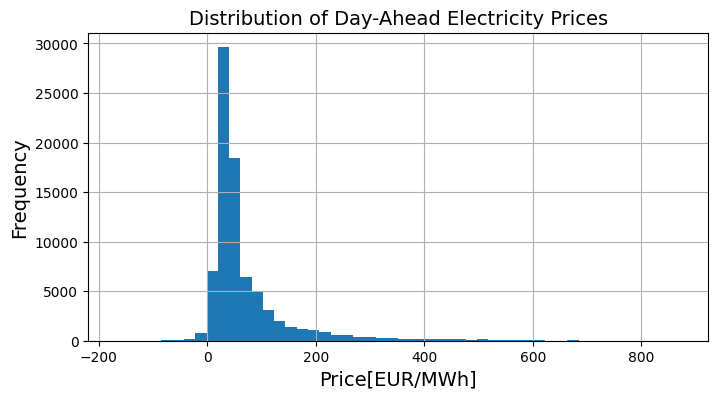

In [45]:
fig, ax = plt.subplots(figsize=(8, 4))
df['Price[EUR/MWh]'].hist(bins=50, ax=ax)
ax.set_title('Distribution of Day-Ahead Electricity Prices', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_xlabel('Price[EUR/MWh]', fontsize=14)

## Adding additional Features
- Hour
- Month
- DayOfWeek

In [46]:
df['DayOfWeek'] = df.index.dayofweek
df['Hour'] = df.index.hour
df['Month'] = df.index.month

* Visualizing Hourly, Weekly and Monthly Average Price

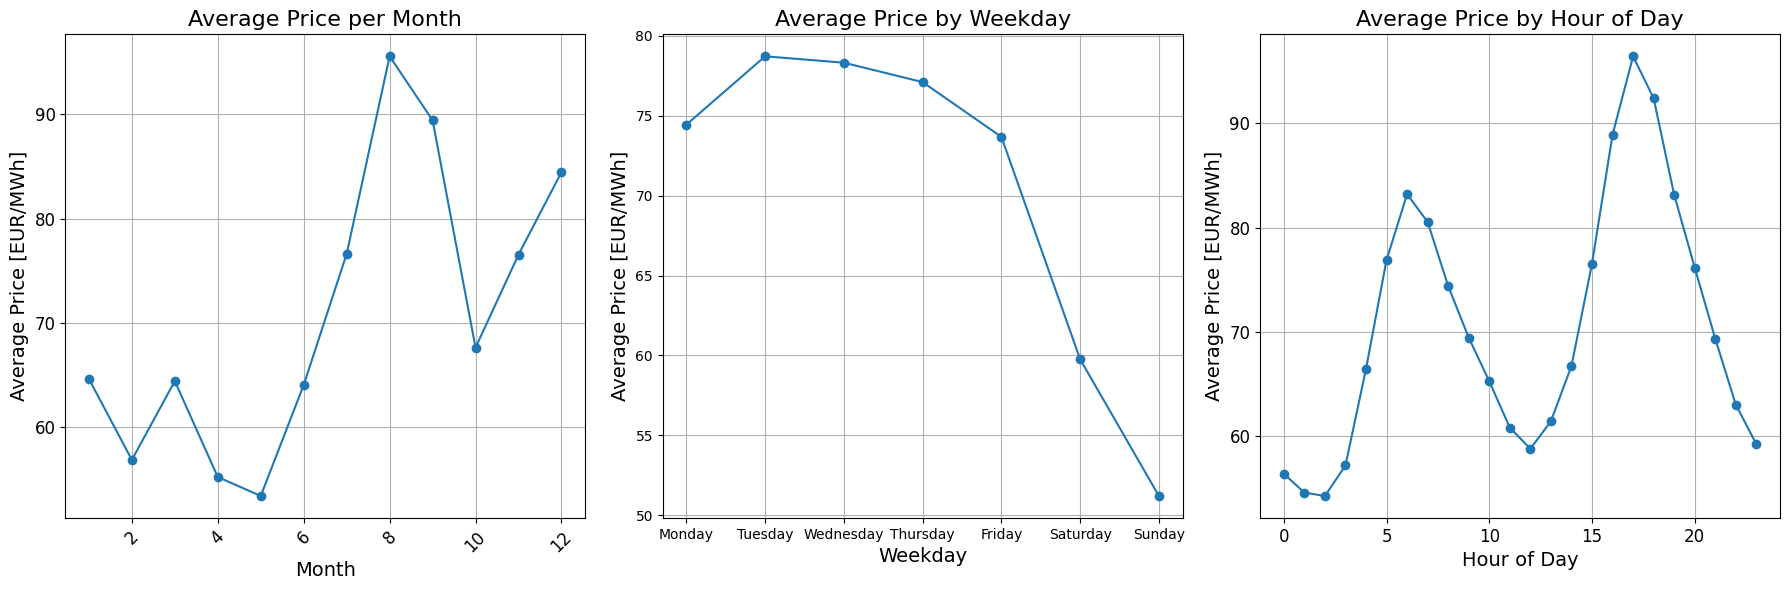

In [47]:
monthly_avg = df.groupby('Month').mean()
weekday_avg = df.groupby('DayOfWeek').mean()
hourly_avg = df.groupby('Hour').mean()


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].plot(monthly_avg.index, monthly_avg['Price[EUR/MWh]'], marker='o', linestyle='-')
axes[0].set_title('Average Price per Month', fontsize=16)
axes[0].set_xlabel('Month', fontsize=14)
axes[0].set_ylabel('Average Price [EUR/MWh]', fontsize=14)
axes[0].tick_params(axis='x', rotation=45, labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].grid(True)

axes[1].plot(weekday_avg.index, weekday_avg['Price[EUR/MWh]'], marker='o')
axes[1].set_title('Average Price by Weekday', fontsize=16)
axes[1].set_xlabel('Weekday', fontsize=14)
axes[1].set_ylabel('Average Price [EUR/MWh]', fontsize=14)
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontsize=10)
axes[1].grid(True)

axes[2].plot(hourly_avg.index, hourly_avg['Price[EUR/MWh]'], marker='o')
axes[2].set_title('Average Price by Hour of Day', fontsize=16)
axes[2].set_xlabel('Hour of Day', fontsize=14)
axes[2].set_ylabel('Average Price [EUR/MWh]', fontsize=14)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=12)
axes[2].grid(True)

plt.tight_layout()
plt.savefig('average_prices.png', dpi=300)
plt.show()


* Visualizing Hourly, Weekly and Monthly Average Actual Load

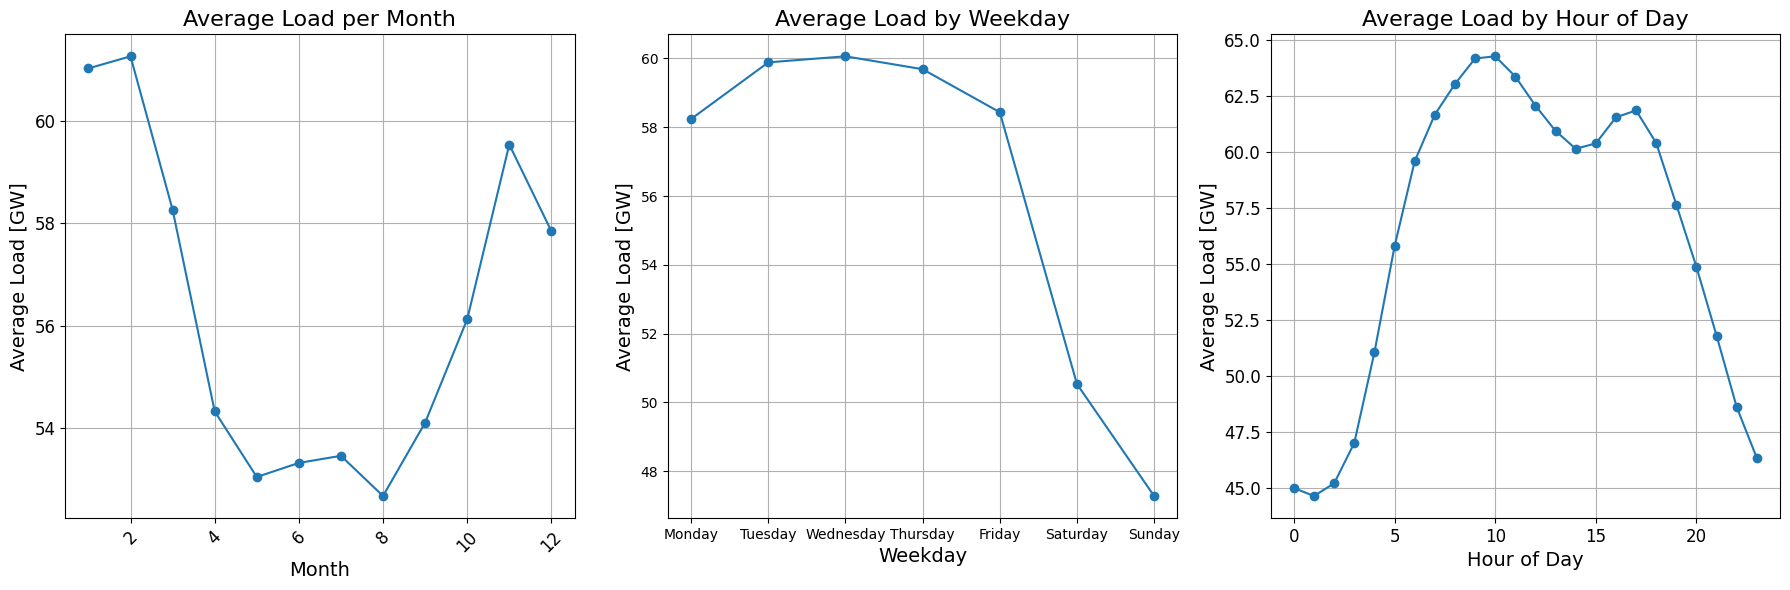

In [48]:
monthly_avg = df.groupby('Month').mean()
weekday_avg = df.groupby('DayOfWeek').mean()
hourly_avg = df.groupby('Hour').mean()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].plot(monthly_avg.index, monthly_avg['Load_Actual[GW]'], marker='o', linestyle='-')
axes[0].set_title('Average Load per Month', fontsize=16)
axes[0].set_xlabel('Month', fontsize=14)
axes[0].set_ylabel('Average Load [GW]', fontsize=14)
axes[0].tick_params(axis='x', rotation=45, labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].grid(True)

axes[1].plot(weekday_avg.index, weekday_avg['Load_Actual[GW]'], marker='o')
axes[1].set_title('Average Load by Weekday', fontsize=16)
axes[1].set_xlabel('Weekday', fontsize=14)
axes[1].set_ylabel('Average Load [GW]', fontsize=14)
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fontsize=10)
axes[1].grid(True)

axes[2].plot(hourly_avg.index, hourly_avg['Load_Actual[GW]'], marker='o')
axes[2].set_title('Average Load by Hour of Day', fontsize=16)
axes[2].set_xlabel('Hour of Day', fontsize=14)
axes[2].set_ylabel('Average Load [GW]', fontsize=14)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=12)
axes[2].grid(True)

plt.tight_layout()

plt.savefig('average_loads.png', dpi=300)
plt.show()


In [49]:
print(f"The Dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

The Dataset has 81622 rows and 21 columns.


# Correlation Coefficient Using Heatmap:

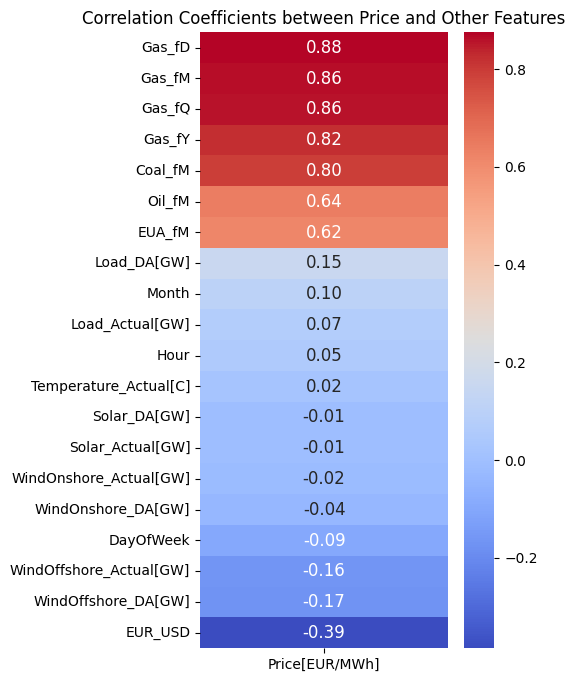

In [52]:
correlations = df.corr(method='pearson')

price_correlations = correlations[['Price[EUR/MWh]']].drop('Price[EUR/MWh]')
price_correlations = price_correlations.sort_values(by='Price[EUR/MWh]', ascending=False)

plt.figure(figsize=(4, 8))
sns.heatmap(price_correlations, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 12})
plt.title('Correlation Coefficients between Price and Other Features')
plt.show()

**Statistical Key Points of the Dataset**

This summary include the following statistical measures for each feature:
  - count: number of instances
  - mean
  - standard deviation
  - maximum and minimum values
  - quartiles:
    - Q1 the first 25% of the data
    - Q2 which is the median of the feature.
    - Q3 the 75% of the data

In [53]:
df.describe()

,Price[EUR/MWh],Load_DA[GW],Load_Actual[GW],Solar_DA[GW],Solar_Actual[GW],WindOnshore_DA[GW],WindOnshore_Actual[GW],WindOffshore_DA[GW],WindOffshore_Actual[GW],Temperature_Actual[C],...,Gas_fD,Gas_fM,Gas_fQ,Gas_fY,Oil_fM,EUA_fM,EUR_USD,DayOfWeek,Hour,Month
count,81622.000000,81622.000000,81622.000000,81622.000000,81622.000000,81622.000000,81622.000000,81622.000000,81622.000000,81622.000000,...,81622.000000,81622.000000,81622.000000,81622.000000,81622.000000,81622.000000,81622.000000,81622.000000,81622.000000,81622.000000
mean,70.459136,54.821877,56.308044,4.984558,4.969457,2.312664,2.336948,10.541694,10.622549,10.944169,...,33.849073,35.069168,36.121485,33.677032,58.871262,34.545503,1.121566,2.999081,11.499755,6.388731
std,84.301112,9.382394,9.979599,7.754830,7.766070,1.775589,1.779058,8.687859,8.796896,7.463306,...,39.175854,41.008777,42.216992,35.398281,18.308535,29.966914,0.052709,1.999660,6.922136,3.472331
min,-167.960000,28.823610,30.908880,0.000000,0.000000,0.001250,0.000000,0.161380,0.074140,-11.750000,...,3.100000,3.535000,4.750000,11.825000,17.800000,3.930000,0.959417,0.000000,0.000000,1.000000
25%,29.280000,47.142295,48.100455,0.000000,0.000000,0.701850,0.748240,3.930182,3.870665,5.120000,...,14.700000,14.900000,15.827000,16.475000,44.770000,7.530000,1.086543,1.000000,5.250000,3.000000
50%,42.000000,54.714130,56.020155,0.178585,0.137985,1.996940,2.022385,7.850610,7.904790,10.400000,...,19.980000,19.675000,19.160000,19.189000,55.720000,24.180000,1.118631,3.000000,11.000000,6.000000
75%,76.237500,62.833265,64.599850,7.766410,7.774958,3.725490,3.698948,14.778665,15.050072,16.450000,...,31.850000,32.970000,35.200000,34.945000,69.960000,61.280000,1.160901,5.000000,17.000000,9.000000
max,871.000000,77.585700,81.077460,41.173940,40.673680,6.772890,7.633420,46.617240,48.023100,35.620000,...,330.000000,310.500000,331.390000,305.000000,117.490000,97.590000,1.251016,6.000000,23.000000,12.000000


In [54]:
# Move 'Price[EUR/MWh]' to the end
target_col = df.pop('Price[EUR/MWh]')
df['Price[EUR/MWh]'] = target_col
df.columns

Index(['Load_DA[GW]', 'Load_Actual[GW]', 'Solar_DA[GW]', 'Solar_Actual[GW]',
       'WindOnshore_DA[GW]', 'WindOnshore_Actual[GW]', 'WindOffshore_DA[GW]',
       'WindOffshore_Actual[GW]', 'Temperature_Actual[C]', 'Coal_fM', 'Gas_fD',
       'Gas_fM', 'Gas_fQ', 'Gas_fY', 'Oil_fM', 'EUA_fM', 'EUR_USD',
       'DayOfWeek', 'Hour', 'Month', 'Price[EUR/MWh]'],
      dtype='object')

# Standardization

To make the model less sensitive to the bias and variance, with keeping the distribution of the data, I use standardization to rescale the data to have the **mean** of '0' and **standared deviation** of '1'.

- Firstly, I defined an empty dictionary to stor the standardizer for each featur in it
- Secondly, I used a for-loop to go over each featur to first fit the scaler, which is finding the mean and variance.
- Thirdly, after reshping the data in the column into a 2D-array, which is a requirement for transformer, I used those parameters from fit step to transform the datapoints.
-  Finaly,  after flattening, which convert the 2D-array back to 1D-array, I saved them in the same column in the dataset.

In [55]:
feature_names =['Load_DA[GW]', 'WindOffshore_DA[GW]','WindOffshore_Actual[GW]','Coal_fM',
                'Gas_fD','Gas_fM', 'Gas_fQ', 'Gas_fY', 'Oil_fM', 'EUA_fM', 'EUR_USD']
target_name = 'Price[EUR/MWh]'

X = df[feature_names].values
y = df[target_name].values

scalers = {i: StandardScaler() for i in range(X.shape[1])}
for i in range(X.shape[1]):
    X[:, i] = scalers[i].fit_transform(X[:, i].reshape(-1, 1)).flatten()

target_scaler = StandardScaler()
y = target_scaler.fit_transform(y.reshape(-1, 1)).flatten()

scaled_df = pd.DataFrame(X, columns=feature_names)
scaled_df[target_name] = y

data = scaled_df.to_numpy()

print(X.shape)
print(y.shape)

(81622, 11)
(81622,)


## Create sliding windows for Timeseries Dataset

In [56]:
def create_sliding_window(data, window_size, prediction_horizon, stride):
    X, y = [], []
    for num in range(0, len(data) - window_size - prediction_horizon + 1, stride):
        X.append(data[num:num + window_size, :])  
        y.append(data[num + window_size:num + window_size + prediction_horizon, -1])  
    return np.array(X), np.array(y)

window_size = 24
prediction_horizon = 24  
stride = 1

X, y = create_sliding_window(data, window_size, prediction_horizon, stride)

## Spliting Dataset Into Training, validation and Test 

In [57]:
train_proportion = 0.8
val_proportion = 0.1
test_proportion = 0.1

total_size = len(X)
train_end = int(train_proportion * total_size)
val_end = int((train_proportion + val_proportion) * total_size)

X_train = X[:train_end]
X_val = X[train_end:val_end]
X_test = X[val_end:]
y_train = y[:train_end]
y_val = y[train_end:val_end]
y_test = y[val_end:]

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (65260, 24, 12)
X_val shape: (8157, 24, 12)
X_test shape: (8158, 24, 12)
y_train shape: (65260, 24)
y_val shape: (8157, 24)
y_test shape: (8158, 24)


# Model's Stracture

To Make the model,
- First, creating a 'Sequential' model from keras.
- Second, adding 'LSTM' layer to capture temporal dependencies in the data.
- Next, adding a Dense layer to transform the output from the LSTM layer into a higher-level feature representation.
- Then, adding 'Dropout' layer to regularize and prevent overfitting..
- Finaly, adding 'dense' layer with 24 units to predict the price for the next 24 hours.

In [58]:
l_rate = 0.001

'''model = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, input_shape=(window_size, len(feature_names)), return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(prediction_horizon)  
])'''

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, input_shape=(window_size, len(feature_names)+1), return_sequences=False),
    tf.keras.layers.RepeatVector(prediction_horizon),  
    tf.keras.layers.LSTM(256, return_sequences=True),  
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))  
])

optimizer_method = tf.keras.optimizers.Adam(learning_rate=l_rate)
loss_function = tf.keras.losses.MeanSquaredError()

early_stopping_conditions = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)

model.compile(optimizer=optimizer_method, loss=loss_function)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               275456    
                                                                 
 repeat_vector (RepeatVecto  (None, 24, 256)           0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 24, 256)           525312    
                                                                 
 time_distributed (TimeDist  (None, 24, 1)             257       
 ributed)                                                        
                                                                 
Total params: 801025 (3.06 MB)
Trainable params: 801025 (3.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training the Model

In this part I save the trained model in a varible called History. It keeps important parameters, like metic, loss value and validation loss value that we are caring about when doing the training. by storing them, they can be used whenever they are needed.
Here are the informtation that we pass to the tarining model:
- training data(X, y)
- number of ecochs which is a limit for stoping the training
- batch size, which define the number of samples that parallelly will be procsees in each training step.
- Validation dataset(X, y)
- early_stop_condtions, which is a limitaion for the training process.


In [59]:
num_of_iter = 500
batch_size = 256

History = model.fit(
    X_train, y_train,
    epochs=num_of_iter,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks= [early_stopping_conditions],
    )

Epoch 1/500

255/255 [==============================] - 95s 349ms/step - loss: 0.0841 - val_loss: 0.7508
Epoch 2/500
255/255 [==============================] - 102s 399ms/step - loss: 0.0637 - val_loss: 0.6998
Epoch 3/500
255/255 [==============================] - 92s 362ms/step - loss: 0.0477 - val_loss: 0.6799
Epoch 4/500
255/255 [==============================] - 92s 361ms/step - loss: 0.0411 - val_loss: 0.7963
Epoch 5/500
255/255 [==============================] - 99s 387ms/step - loss: 0.0349 - val_loss: 0.7514
Epoch 6/500
255/255 [==============================] - 102s 401ms/step - loss: 0.0306 - val_loss: 0.6928
Epoch 7/500
255/255 [==============================] - 102s 402ms/step - loss: 0.0258 - val_loss: 0.6797
Epoch 8/500
255/255 [==============================] - 102s 401ms/step - loss: 0.0225 - val_loss: 0.6749
Epoch 9/500
255/255 [==============================] - 102s 398ms/step - loss: 0.0205 - val_loss: 0.6602
Epoch 10/500
255/255 [==============================] - 10

# Making Predictions

In this part,
- Trained model is used to predict the values for X_test.
- The mean and variance stored in standardizer dictionary is uesed to rescale the predicted and actual values to their original scale.
- mean absolute error as a metric performance is calculated.

In [60]:
y_predicted = model.predict(X_test)
y_predicted_reshaped = y_predicted.reshape(-1, 1)

y_test_inv = target_scaler.inverse_transform(y_test)
y_predicted_inv = target_scaler.inverse_transform(y_predicted_reshaped)

y_test_flat = y_test_inv.flatten()
y_predicted_flat = y_predicted_inv.flatten()

mae = mean_absolute_error(y_test_flat, y_predicted_flat)
print("Models Performance using (MAE):", mae)

255/255 [==============================] - 13s 43ms/step
Models Performance using (MAE): 24.029342302985224


## Actual vs. Predicted Price Graph

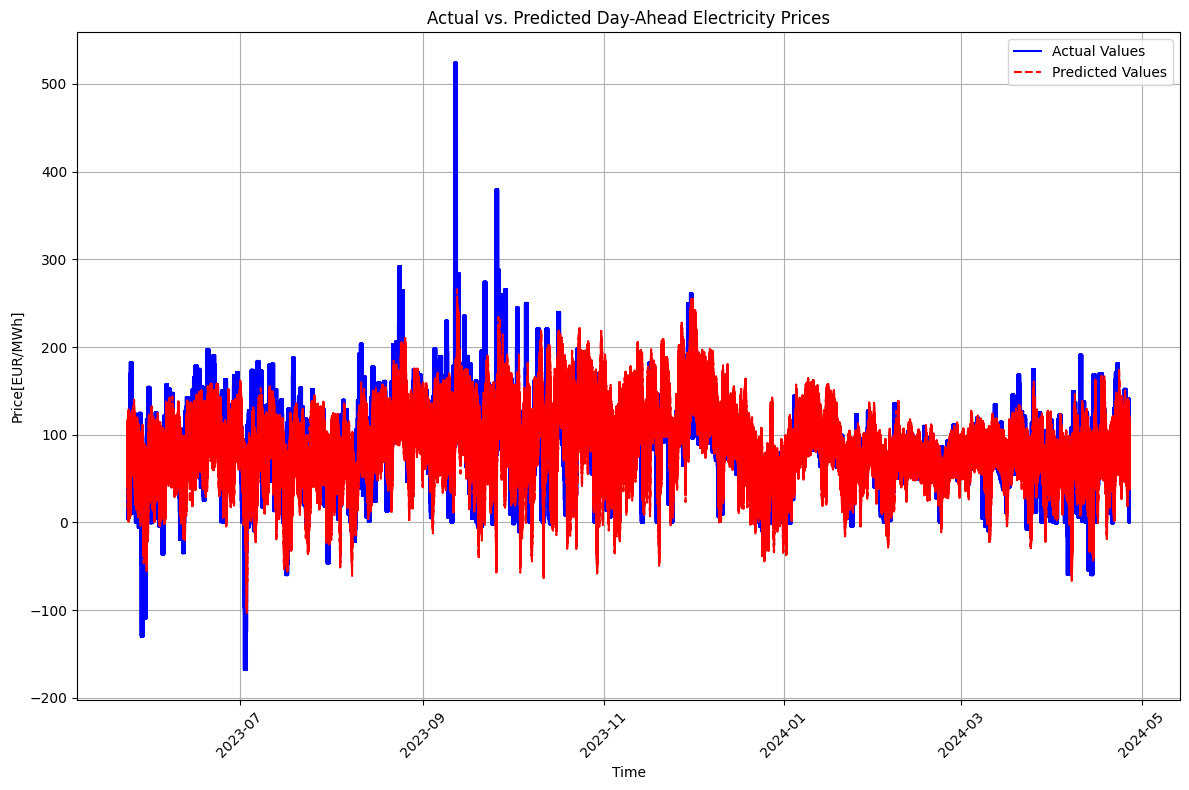

In [62]:
start_date = pd.Timestamp('2023-05-24')
end_date = pd.Timestamp('2024-04-27')

date_range = pd.date_range(start=start_date, end=end_date, periods=len(y_test_flat))

plt.figure(figsize=(12, 8))
plt.plot(date_range, y_test_flat, label='Actual Values', color='blue', linestyle='-')
plt.plot(date_range, y_predicted_flat, label='Predicted Values', color='red', linestyle='--')
plt.title('Actual vs. Predicted Day-Ahead Electricity Prices')
plt.xlabel('Time')
plt.ylabel('Price[EUR/MWh]')
plt.legend(loc='upper right')
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout()       
plt.show()


## RandomForestQuantileRegressor with Train_test_split Method

In [63]:
feature_names =['Load_DA[GW]', 'WindOffshore_DA[GW]','WindOffshore_Actual[GW]','Coal_fM',
                'Gas_fD','Gas_fM', 'Gas_fQ', 'Gas_fY', 'Oil_fM', 'EUA_fM', 'EUR_USD']

target_name = 'Price[EUR/MWh]'

# Feature and target separation
X = df[feature_names].values
y = df[target_name].values

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (65297, 11)
X_test shape: (16325, 11)
y_train shape: (65297,)
y_test shape: (16325,)


In [65]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [66]:
qrf_model = RandomForestQuantileRegressor()

qrf_model.fit(X_train, y_train)

quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
y_pred_quantiles = qrf_model.predict(X_test, quantiles=quantiles)

y_pred_10 = y_pred_quantiles[:, 0]
y_pred_25 = y_pred_quantiles[:, 1]
y_pred_50 = y_pred_quantiles[:, 2]
y_pred_75 = y_pred_quantiles[:, 3]
y_pred_90 = y_pred_quantiles[:, 4]

print(f"10th Percentile Predictions Shape: {y_pred_10.shape}")
print(f"25th Percentile Predictions Shape: {y_pred_25.shape}")
print(f"50th Percentile Predictions Shape: {y_pred_50.shape}")
print(f"75th Percentile Predictions Shape: {y_pred_75.shape}")
print(f"90th Percentile Predictions Shape: {y_pred_90.shape}")

10th Percentile Predictions Shape: (16325,)
25th Percentile Predictions Shape: (16325,)
50th Percentile Predictions Shape: (16325,)
75th Percentile Predictions Shape: (16325,)
90th Percentile Predictions Shape: (16325,)


In [67]:
def quantile_loss(y_true, y_pred, quantile):
    error = y_true - y_pred
    loss = np.mean(np.maximum(quantile * error, (quantile - 1) * error))
    return loss

loss_10 = quantile_loss(y_test, y_pred_10, 0.1)
loss_25 = quantile_loss(y_test, y_pred_25, 0.25)
loss_50 = quantile_loss(y_test, y_pred_50, 0.5)
loss_75 = quantile_loss(y_test, y_pred_75, 0.75)
loss_90 = quantile_loss(y_test, y_pred_90, 0.9)

print(f"10th Percentile Loss: {loss_10}")
print(f"25th Percentile Loss: {loss_25}")
print(f"50th Percentile Loss: {loss_50}")
print(f"75th Percentile Loss: {loss_75}")
print(f"90th Percentile Loss: {loss_90}")


10th Percentile Loss: 2.00894804287902
25th Percentile Loss: 3.4511623277182233
50th Percentile Loss: 4.366649770290964
75th Percentile Loss: 3.552765543644717
90th Percentile Loss: 2.082210358346095


In [68]:
results_df = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted 10th Percentile': y_pred_10,
    'Predicted 25th Percentile': y_pred_25,
    'Predicted 50th Percentile': y_pred_50,
    'Predicted 75th Percentile': y_pred_75,
    'Predicted 90th Percentile': y_pred_90
})

results_df.head()


,Actual Price,Predicted 10th Percentile,Predicted 25th Percentile,Predicted 50th Percentile,Predicted 75th Percentile,Predicted 90th Percentile
0,26.47,30.410,30.41,33.910,45.9200,48.490
1,29.70,25.180,26.89,30.355,32.3375,36.066
2,383.91,337.890,367.20,374.700,397.9100,398.970
3,53.93,47.978,50.17,54.975,59.9325,62.231
4,11.92,10.540,14.24,14.960,23.4000,32.275


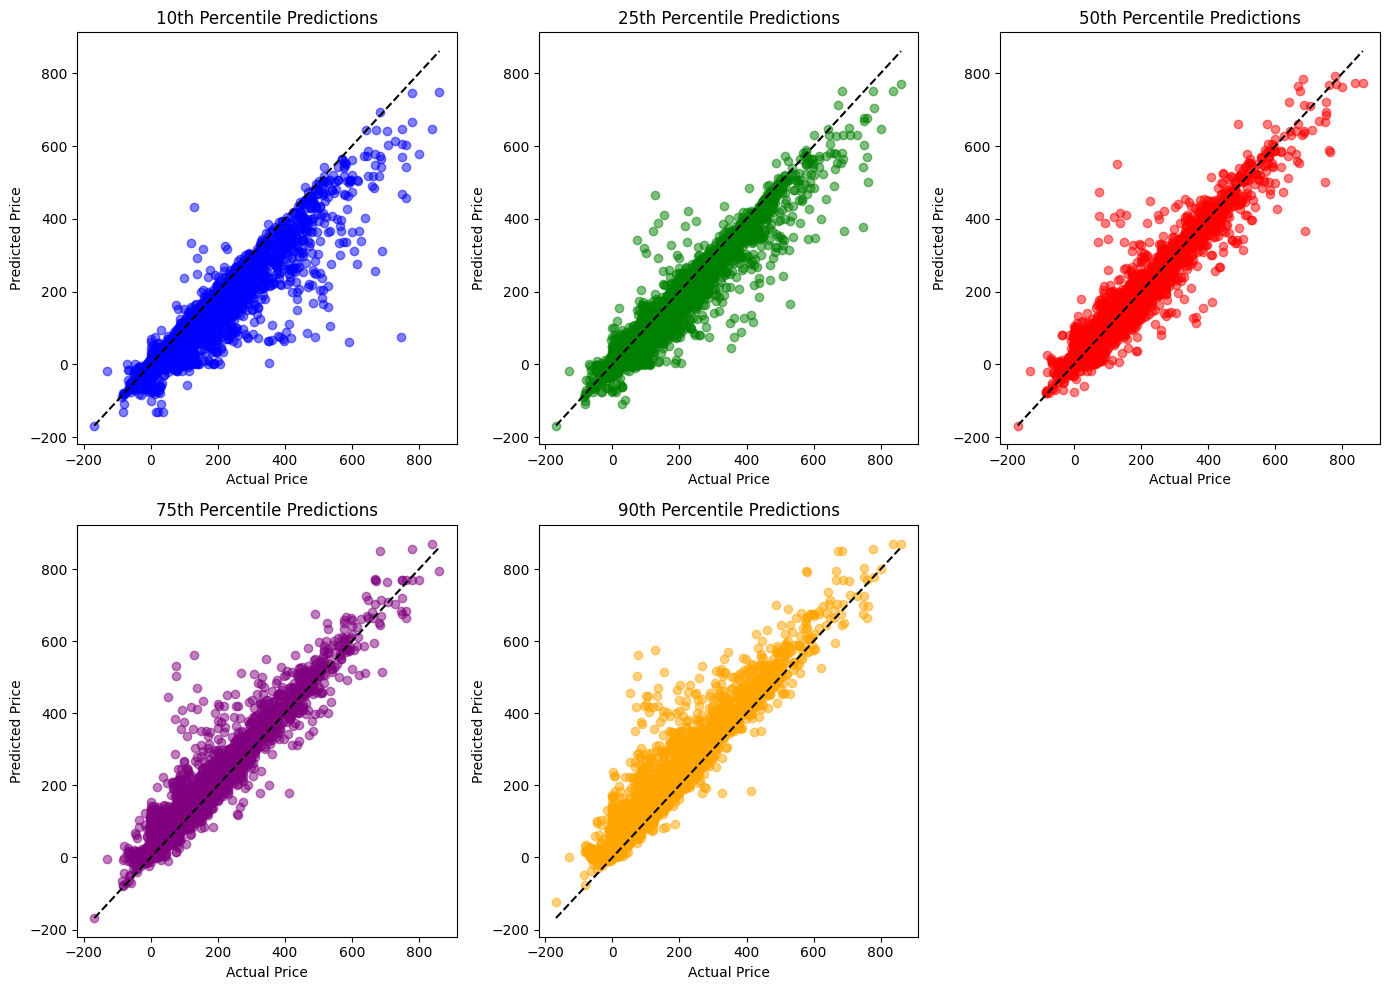

In [69]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 3, 1)
plt.scatter(y_test, y_pred_10, alpha=0.5, color='blue')
plt.title('10th Percentile Predictions')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--')

plt.subplot(2, 3, 2)
plt.scatter(y_test, y_pred_25, alpha=0.5, color='green')
plt.title('25th Percentile Predictions')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--')

plt.subplot(2, 3, 3)
plt.scatter(y_test, y_pred_50, alpha=0.5, color='red')
plt.title('50th Percentile Predictions')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--')

plt.subplot(2, 3, 4)
plt.scatter(y_test, y_pred_75, alpha=0.5, color='purple')
plt.title('75th Percentile Predictions')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--')

plt.subplot(2, 3, 5)
plt.scatter(y_test, y_pred_90, alpha=0.5, color='orange')
plt.title('90th Percentile Predictions')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--')


plt.tight_layout()
plt.show()


In [ ]:
y_pred_50_flat = y_pred_50.flatten()
y_test_flat = y_test_flat.flatten()

mae_50 = mean_absolute_error(y_test, y_pred_50_flat)
print(f"50th Percentile MAE: {mae_50}")

## RandomForestQuantileRegressor with Sliding window Method

In [72]:
feature_names =['Load_DA[GW]', 'WindOffshore_DA[GW]','WindOffshore_Actual[GW]','Coal_fM',
                'Gas_fD','Gas_fM', 'Gas_fQ', 'Gas_fY', 'Oil_fM', 'EUA_fM', 'EUR_USD']
target_name = 'Price[EUR/MWh]'

X = df[feature_names].values
y = df[target_name].values



scalers = {i: StandardScaler() for i in range(X.shape[1])}
for i in range(X.shape[1]):
    X[:, i] = scalers[i].fit_transform(X[:, i].reshape(-1, 1)).flatten()

target_scaler = StandardScaler()
y = target_scaler.fit_transform(y.reshape(-1, 1)).flatten()

scaled_df = pd.DataFrame(X, columns=feature_names)
scaled_df[target_name] = y
data = scaled_df.to_numpy()



def create_sliding_window(data, window_size, prediction_horizon, stride):
    X, y = [], []
    for num in range(0, len(data) - window_size - prediction_horizon + 1, stride):
        X.append(data[num:num + window_size, :])  
        y.append(data[num + window_size:num + window_size + prediction_horizon, -1]) 
    return np.array(X), np.array(y)

window_size = 24
prediction_horizon = 24  
stride = 1

X, y = create_sliding_window(data, window_size, prediction_horizon, stride)

train_proportion = 0.8
val_proportion = 0.1
test_proportion = 0.1

total_size = len(X)
train_end = int(train_proportion * total_size)
val_end = int((train_proportion + val_proportion) * total_size)

X_train = X[:train_end]
X_val = X[train_end:val_end]
X_test = X[val_end:]
y_train = y[:train_end]
y_val = y[train_end:val_end]
y_test = y[val_end:]

X_train_flat = X_train.reshape(X_train.shape[0], -1)  
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

y_train_flat = y_train.reshape(y_train.shape[0], -1)  
y_val_flat = y_val.reshape(y_val.shape[0], -1)
y_test_flat = y_test.reshape(y_test.shape[0], -1)


qrf_model = RandomForestQuantileRegressor()
qrf_model.fit(X_train_flat, y_train_flat)

quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
y_pred_quantiles = qrf_model.predict(X_test_flat, quantiles=quantiles)


y_pred_10 = y_pred_quantiles[:, :, 0]  
y_pred_25 = y_pred_quantiles[:, :, 1]
y_pred_50 = y_pred_quantiles[:, :, 2]
y_pred_75 = y_pred_quantiles[:, :, 3]
y_pred_90 = y_pred_quantiles[:, :, 4]

y_pred_10_flat = y_pred_10.flatten()
y_pred_25_flat = y_pred_25.flatten()
y_pred_50_flat = y_pred_50.flatten()
y_pred_75_flat = y_pred_75.flatten()
y_pred_90_flat = y_pred_90.flatten()

y_test_flat = y_test_flat.flatten()


def quantile_loss(y_true, y_pred, quantile):
    error = y_true - y_pred
    loss = np.mean(np.maximum(quantile * error, (quantile - 1) * error))
    return loss


loss_10 = quantile_loss(y_test_flat, y_pred_10_flat, 0.1)
loss_25 = quantile_loss(y_test_flat, y_pred_25_flat, 0.25)
loss_50 = quantile_loss(y_test_flat, y_pred_50_flat, 0.5)
loss_75 = quantile_loss(y_test_flat, y_pred_75_flat, 0.75)
loss_90 = quantile_loss(y_test_flat, y_pred_90_flat, 0.9)

print(f"10th Percentile Loss: {loss_10}")
print(f"25th Percentile Loss: {loss_25}")
print(f"50th Percentile Loss: {loss_50}")
print(f"75th Percentile Loss: {loss_75}")
print(f"90th Percentile Loss: {loss_90}")

10th Percentile Loss: 0.07645478708527872
25th Percentile Loss: 0.12330050428939635
50th Percentile Loss: 0.1489469478788601
75th Percentile Loss: 0.1264261411678633
90th Percentile Loss: 0.07876022006307694


In [73]:
y_test_original = target_scaler.inverse_transform(y_test_flat.reshape(-1, 1)).flatten()
y_pred_10_original = target_scaler.inverse_transform(y_pred_10_flat.reshape(-1, 1)).flatten()
y_pred_25_original = target_scaler.inverse_transform(y_pred_25_flat.reshape(-1, 1)).flatten()
y_pred_50_original = target_scaler.inverse_transform(y_pred_50_flat.reshape(-1, 1)).flatten()
y_pred_75_original = target_scaler.inverse_transform(y_pred_75_flat.reshape(-1, 1)).flatten()
y_pred_90_original = target_scaler.inverse_transform(y_pred_90_flat.reshape(-1, 1)).flatten()


results_df = pd.DataFrame({
    'Actual Price': y_test_original,
    'Predicted 10th Percentile': y_pred_10_original,
    'Predicted 25th Percentile': y_pred_25_original,
    'Predicted 50th Percentile': y_pred_50_original,
    'Predicted 75th Percentile': y_pred_75_original,
    'Predicted 90th Percentile': y_pred_90_original
})

results_df.head()

,Actual Price,Predicted 10th Percentile,Predicted 25th Percentile,Predicted 50th Percentile,Predicted 75th Percentile,Predicted 90th Percentile
0,77.09,70.070,73.0550,77.700,82.5325,89.397
1,69.58,69.029,71.5475,76.935,81.5825,88.904
2,70.00,67.876,72.2250,75.945,82.4550,95.963
3,78.64,67.876,72.4950,78.065,91.8650,110.198
4,101.09,70.618,75.8600,83.770,107.0550,126.914


In [ ]:

mae_50 = mean_absolute_error(y_test_original, y_pred_50_original)
print(f"50th Percentile MAE: {mae_50}")